## First try

In [ ]:
# !pip install torch torchvision

In [5]:
!python --version

Python 3.10.19


In [13]:
# imports 
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [14]:
# define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [23]:
torch.manual_seed(10)

#### Handle input

Everything in this section does not change

In [24]:
# define directory
data_dir = "./data"

# transform to convert input into pytorch tensor
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# train and test data 
train_dataset = datasets.ImageFolder(root = os.path.join(data_dir, "train"), transform = transform)
test_dataset  = datasets.ImageFolder(root = os.path.join(data_dir, "test"), transform = transform)

# data loader objects for efficient batch processing during training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
X_train = []
y_train = []
for X, y in train_loader:
    X_train.append(X)
    y_train.append(y)
# concatenate into one tensor
X_train = torch.cat(X_train, dim = 0)
y_train = torch.cat(y_train, dim = 0)

X_test = []
y_test = []
for X, y in test_loader:
    X_test.append(X)
    y_test.append(y)
# concatenate into one tensor
X_test = torch.cat(X_test, dim = 0)
y_test = torch.cat(y_test, dim = 0)

In [26]:
# define input dims and num classes
input_dim = 224 * 224 * 3
num_classes = len(train_dataset.classes)

#### Defining some functions

In [59]:
def run_and_plot(model, optimizer, criterion, num_epochs = 100):
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # training
        model.train()
        
        # forward
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
    
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_losses.append(loss.item())
    
        # testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_losses.append(test_loss)
    
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")
    
    # plot
    plt.figure(figsize = (8,5))
    plt.plot(train_losses, label = "Training loss")
    plt.plot(test_losses, label = "Testing loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs testing loss")
    plt.legend()
    plt.grid()
    plt.show()

In [60]:
def get_f1(model):
    with torch.no_grad():
        train_preds = model(X_train).argmax(dim = 1).cpu().numpy()
        train_labels = y_train.cpu().numpy()
        train_f1 = f1_score(train_labels, train_preds, average = "macro")
    
        test_preds = model(X_test).argmax(dim = 1).cpu().numpy()
        test_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_labels, test_preds, average = "macro")
    
    print(f"Train F1: {train_f1:.4f} \nTest F1: {test_f1:.4f}")
    return train_f1, test_f1

#### Defining the class of the DNN

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # flatten input
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 
model_1 = NeuralNetwork().to(device)
print(model_1)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


**Architecture**: Linear(150528 → 512) → ReLU → Linear(512 → 256) → ReLU → Linear(256 → 4)

In [53]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

Epoch [10/100], Train Loss: 15.7723, Test Loss: 14.7662
Epoch [20/100], Train Loss: 4.5855, Test Loss: 6.2292
Epoch [30/100], Train Loss: 3.3525, Test Loss: 1.7118
Epoch [40/100], Train Loss: 1.3773, Test Loss: 1.4959
Epoch [50/100], Train Loss: 1.4383, Test Loss: 1.2992
Epoch [60/100], Train Loss: 1.2878, Test Loss: 1.2912
Epoch [70/100], Train Loss: 1.2372, Test Loss: 1.2683
Epoch [80/100], Train Loss: 1.2171, Test Loss: 1.2318
Epoch [90/100], Train Loss: 1.2004, Test Loss: 1.2279
Epoch [100/100], Train Loss: 1.1854, Test Loss: 1.2140


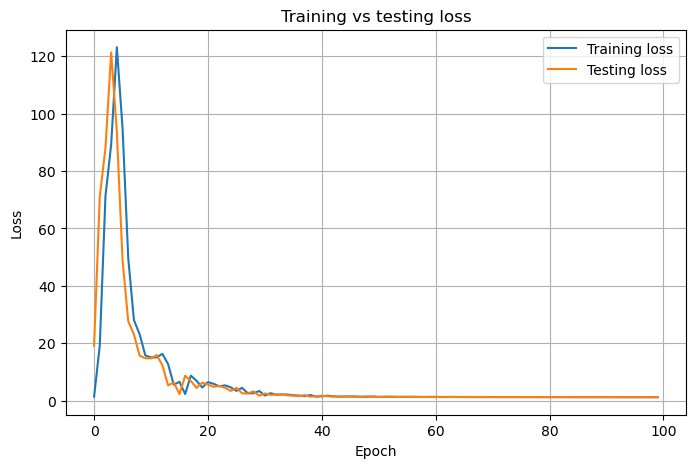

In [30]:
run_and_plot(model_1, optimizer, criterion, num_epochs = 100)

The results are bad, the training f1 is low so there is a high bias so we need to fix it by:
- Adding more layers
- Adding more neurons
- Changing the activation functions
- Changing the weight initialization
- Cahnging optimizer

In [31]:
get_f1(model_1)

Train F1: 0.48014752162967256 
Test F1: 0.4605385594880501


#### Using Leaky ReLU, eveyrthing else is the same

In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # flatten input
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 
model_2 = NeuralNetwork().to(device)
print(model_2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [36]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

Epoch [10/100], Train Loss: 17.1220, Test Loss: 19.6200
Epoch [20/100], Train Loss: 7.9426, Test Loss: 6.5623
Epoch [30/100], Train Loss: 2.6998, Test Loss: 2.7666
Epoch [40/100], Train Loss: 2.8529, Test Loss: 1.5294
Epoch [50/100], Train Loss: 1.6651, Test Loss: 1.5667
Epoch [60/100], Train Loss: 1.2465, Test Loss: 1.3648
Epoch [70/100], Train Loss: 1.2578, Test Loss: 1.3552
Epoch [80/100], Train Loss: 1.2502, Test Loss: 1.2319
Epoch [90/100], Train Loss: 1.1977, Test Loss: 1.2144
Epoch [100/100], Train Loss: 1.1571, Test Loss: 1.2080


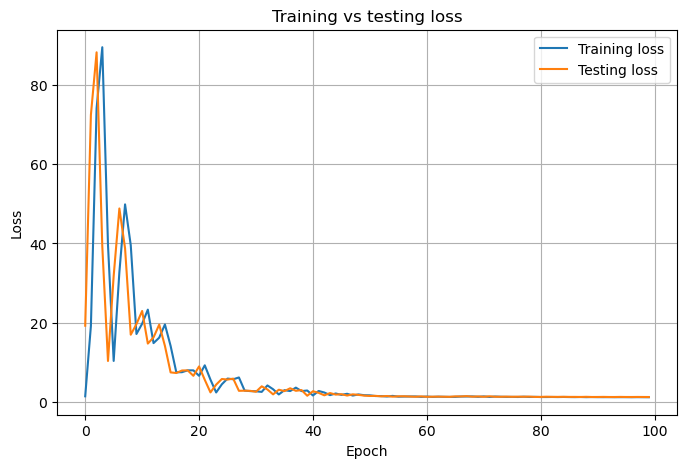

In [37]:
run_and_plot(model_2, optimizer, criterion, num_epochs = 100)

In [38]:
get_f1(model_2)

Train F1: 0.5112999599675203 
Test F1: 0.44631383204576425


Increased the training f1 but the test one decreased a bit, but for now work on increasing the training, then apply regularization

#### More complex architecture + different learning rates

In [61]:
class ComplexNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # flatten input
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Output layer
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 
model_3 = ComplexNeuralNetwork().to(device)
print(model_3)

ComplexNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=256, bi

In [62]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [63]:
import random

Epoch [10/100], Train Loss: 0.9016, Test Loss: 59.8812
Epoch [20/100], Train Loss: 0.7353, Test Loss: 12.6409
Epoch [30/100], Train Loss: 0.5938, Test Loss: 2.3683
Epoch [40/100], Train Loss: 0.5034, Test Loss: 1.1226
Epoch [50/100], Train Loss: 0.4089, Test Loss: 0.9259
Epoch [60/100], Train Loss: 0.3656, Test Loss: 1.0020
Epoch [70/100], Train Loss: 0.3139, Test Loss: 1.1619
Epoch [80/100], Train Loss: 0.2208, Test Loss: 1.0829
Epoch [90/100], Train Loss: 0.1686, Test Loss: 1.1751
Epoch [100/100], Train Loss: 0.1557, Test Loss: 1.2021


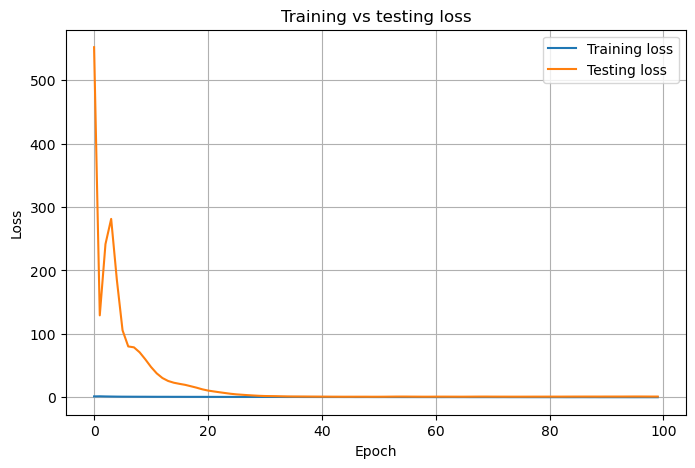

Train F1: 0.9890 
Test F1: 0.7094
Epoch [10/100], Train Loss: 1.0814, Test Loss: 77.6884
Epoch [20/100], Train Loss: 0.6838, Test Loss: 6.6237
Epoch [30/100], Train Loss: 0.4064, Test Loss: 1.8578
Epoch [40/100], Train Loss: 0.1944, Test Loss: 1.7780
Epoch [50/100], Train Loss: 0.1075, Test Loss: 2.5144
Epoch [60/100], Train Loss: 0.0746, Test Loss: 2.3358
Epoch [70/100], Train Loss: 0.0431, Test Loss: 5.3892
Epoch [80/100], Train Loss: 0.0343, Test Loss: 2.7541
Epoch [90/100], Train Loss: 0.0539, Test Loss: 3.5756
Epoch [100/100], Train Loss: 0.0220, Test Loss: 2.8836


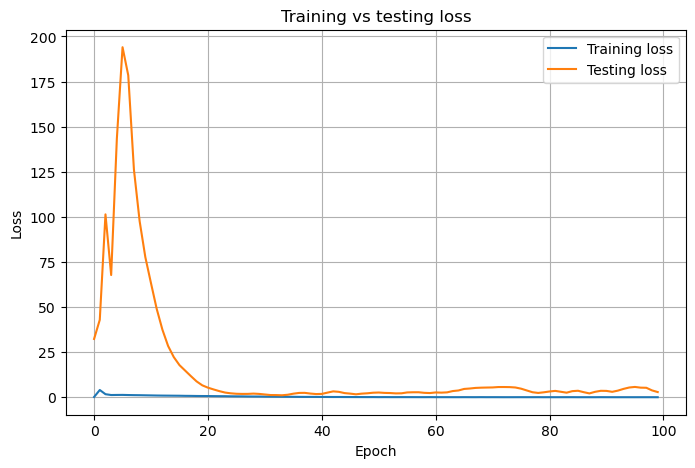

Train F1: 0.7038 
Test F1: 0.4401
Epoch [10/100], Train Loss: 0.0363, Test Loss: 2.9674
Epoch [20/100], Train Loss: 0.0182, Test Loss: 4.3136
Epoch [30/100], Train Loss: 0.0137, Test Loss: 1.8486
Epoch [40/100], Train Loss: 0.0083, Test Loss: 3.7563
Epoch [50/100], Train Loss: 0.0067, Test Loss: 2.8928
Epoch [60/100], Train Loss: 0.0098, Test Loss: 2.2926
Epoch [70/100], Train Loss: 0.0067, Test Loss: 2.1785
Epoch [80/100], Train Loss: 0.0044, Test Loss: 2.3636
Epoch [90/100], Train Loss: 0.0179, Test Loss: 2.5046
Epoch [100/100], Train Loss: 0.0094, Test Loss: 2.4566


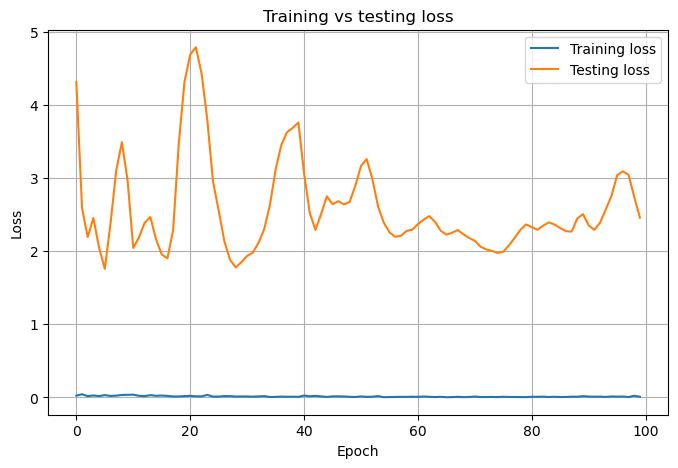

Train F1: 0.9474 
Test F1: 0.6113
Epoch [10/100], Train Loss: 0.3646, Test Loss: 67.6456
Epoch [20/100], Train Loss: 0.0878, Test Loss: 8.9912
Epoch [30/100], Train Loss: 0.0477, Test Loss: 6.4225
Epoch [40/100], Train Loss: 0.0441, Test Loss: 3.9757
Epoch [50/100], Train Loss: 0.0293, Test Loss: 5.1546
Epoch [60/100], Train Loss: 0.0284, Test Loss: 4.4179
Epoch [70/100], Train Loss: 0.0210, Test Loss: 3.3171
Epoch [80/100], Train Loss: 0.0146, Test Loss: 3.3546
Epoch [90/100], Train Loss: 0.0106, Test Loss: 3.4959
Epoch [100/100], Train Loss: 0.0242, Test Loss: 3.3825


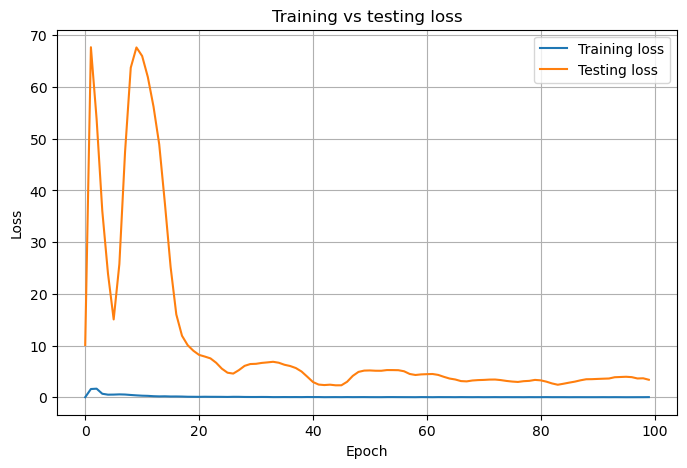

Train F1: 0.7395 
Test F1: 0.4864
Epoch [10/100], Train Loss: 0.3099, Test Loss: 41.8749
Epoch [20/100], Train Loss: 0.0831, Test Loss: 8.8736
Epoch [30/100], Train Loss: 0.0510, Test Loss: 5.5141
Epoch [40/100], Train Loss: 0.0397, Test Loss: 3.0008
Epoch [50/100], Train Loss: 0.0256, Test Loss: 3.0486
Epoch [60/100], Train Loss: 0.0129, Test Loss: 2.9279
Epoch [70/100], Train Loss: 0.0137, Test Loss: 2.8784
Epoch [80/100], Train Loss: 0.0087, Test Loss: 4.4932
Epoch [90/100], Train Loss: 0.0252, Test Loss: 4.8642
Epoch [100/100], Train Loss: 0.0145, Test Loss: 3.7073


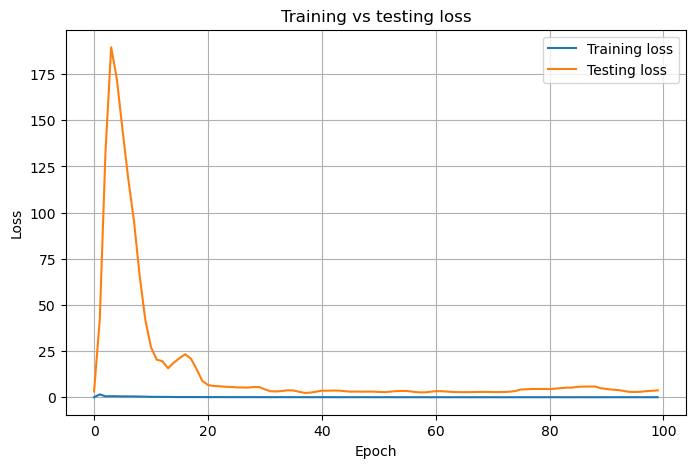

Train F1: 0.6678 
Test F1: 0.4082
Epoch [10/100], Train Loss: 0.1175, Test Loss: 6.3071
Epoch [20/100], Train Loss: 0.0823, Test Loss: 5.6244
Epoch [30/100], Train Loss: 0.0307, Test Loss: 4.3138
Epoch [40/100], Train Loss: 0.0477, Test Loss: 4.6005
Epoch [50/100], Train Loss: 0.0283, Test Loss: 3.4444
Epoch [60/100], Train Loss: 0.0149, Test Loss: 3.0523
Epoch [70/100], Train Loss: 0.0191, Test Loss: 2.9558
Epoch [80/100], Train Loss: 0.0110, Test Loss: 2.3496
Epoch [90/100], Train Loss: 0.0127, Test Loss: 5.6709
Epoch [100/100], Train Loss: 0.0144, Test Loss: 3.4747


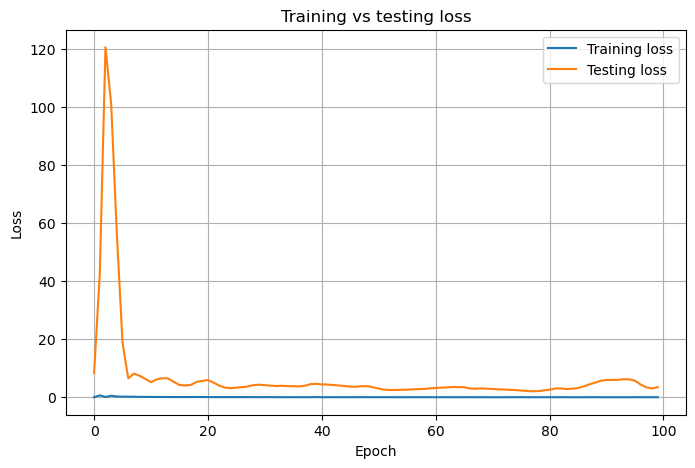

Train F1: 0.7184 
Test F1: 0.5145
Epoch [10/100], Train Loss: 0.0109, Test Loss: 2.3456
Epoch [20/100], Train Loss: 0.0091, Test Loss: 2.1686
Epoch [30/100], Train Loss: 0.0107, Test Loss: 2.0551
Epoch [40/100], Train Loss: 0.0077, Test Loss: 2.0137
Epoch [50/100], Train Loss: 0.0041, Test Loss: 1.9845
Epoch [60/100], Train Loss: 0.0034, Test Loss: 1.9988
Epoch [70/100], Train Loss: 0.0056, Test Loss: 2.0162
Epoch [80/100], Train Loss: 0.0024, Test Loss: 2.0297
Epoch [90/100], Train Loss: 0.0040, Test Loss: 2.0468
Epoch [100/100], Train Loss: 0.0145, Test Loss: 2.0492


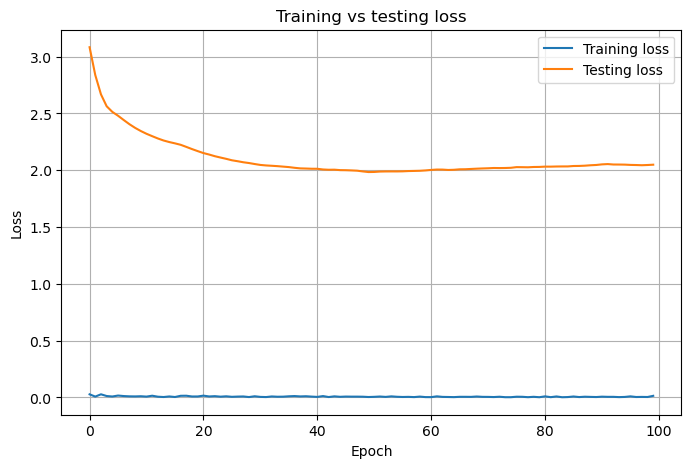

Train F1: 0.9987 
Test F1: 0.7073
Epoch [10/100], Train Loss: 0.0044, Test Loss: 2.0510
Epoch [20/100], Train Loss: 0.0028, Test Loss: 2.0664
Epoch [30/100], Train Loss: 0.0026, Test Loss: 2.0603
Epoch [40/100], Train Loss: 0.0024, Test Loss: 2.0537
Epoch [50/100], Train Loss: 0.0029, Test Loss: 2.0339
Epoch [60/100], Train Loss: 0.0028, Test Loss: 2.0357
Epoch [70/100], Train Loss: 0.0037, Test Loss: 2.0476
Epoch [80/100], Train Loss: 0.0036, Test Loss: 2.0715
Epoch [90/100], Train Loss: 0.0021, Test Loss: 2.0742
Epoch [100/100], Train Loss: 0.0030, Test Loss: 2.0801


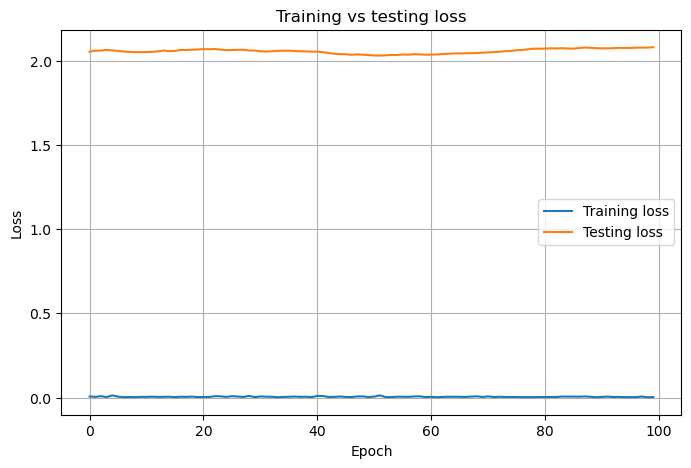

Train F1: 0.9987 
Test F1: 0.6773
Epoch [10/100], Train Loss: 0.0028, Test Loss: 2.0885
Epoch [20/100], Train Loss: 0.0022, Test Loss: 2.1264
Epoch [30/100], Train Loss: 0.0032, Test Loss: 2.1684
Epoch [40/100], Train Loss: 0.0019, Test Loss: 2.1446
Epoch [50/100], Train Loss: 0.0028, Test Loss: 2.1924
Epoch [60/100], Train Loss: 0.0031, Test Loss: 2.1674
Epoch [70/100], Train Loss: 0.0018, Test Loss: 2.1727
Epoch [80/100], Train Loss: 0.0025, Test Loss: 2.1870
Epoch [90/100], Train Loss: 0.0024, Test Loss: 2.2397
Epoch [100/100], Train Loss: 0.0032, Test Loss: 2.2414


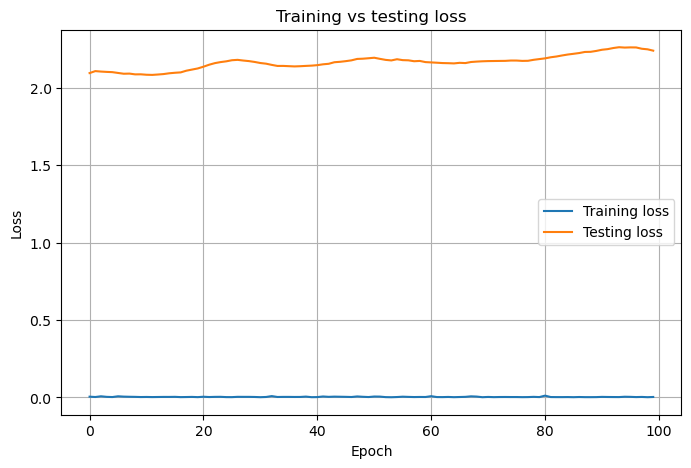

Train F1: 0.9987 
Test F1: 0.6712
Epoch [10/100], Train Loss: 0.0020, Test Loss: 2.4134
Epoch [20/100], Train Loss: 0.0033, Test Loss: 2.3822
Epoch [30/100], Train Loss: 0.0072, Test Loss: 2.2895
Epoch [40/100], Train Loss: 0.0038, Test Loss: 2.2828
Epoch [50/100], Train Loss: 0.0022, Test Loss: 2.3338
Epoch [60/100], Train Loss: 0.0023, Test Loss: 2.4600
Epoch [70/100], Train Loss: 0.0071, Test Loss: 2.6430
Epoch [80/100], Train Loss: 0.0150, Test Loss: 2.6100
Epoch [90/100], Train Loss: 0.0026, Test Loss: 2.7230
Epoch [100/100], Train Loss: 0.0027, Test Loss: 2.8394


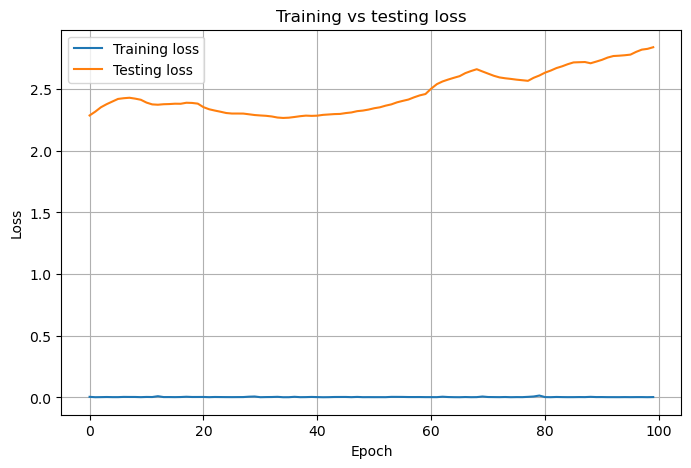

Train F1: 0.9987 
Test F1: 0.6976
Epoch [10/100], Train Loss: 0.0025, Test Loss: 3.1493
Epoch [20/100], Train Loss: 0.0039, Test Loss: 3.4003
Epoch [30/100], Train Loss: 0.0041, Test Loss: 2.7774
Epoch [40/100], Train Loss: 0.0037, Test Loss: 4.5091
Epoch [50/100], Train Loss: 0.0095, Test Loss: 3.0503
Epoch [60/100], Train Loss: 0.0065, Test Loss: 2.7687
Epoch [70/100], Train Loss: 0.0023, Test Loss: 2.9893
Epoch [80/100], Train Loss: 0.0038, Test Loss: 2.3394
Epoch [90/100], Train Loss: 0.0028, Test Loss: 2.4476
Epoch [100/100], Train Loss: 0.0032, Test Loss: 2.7177


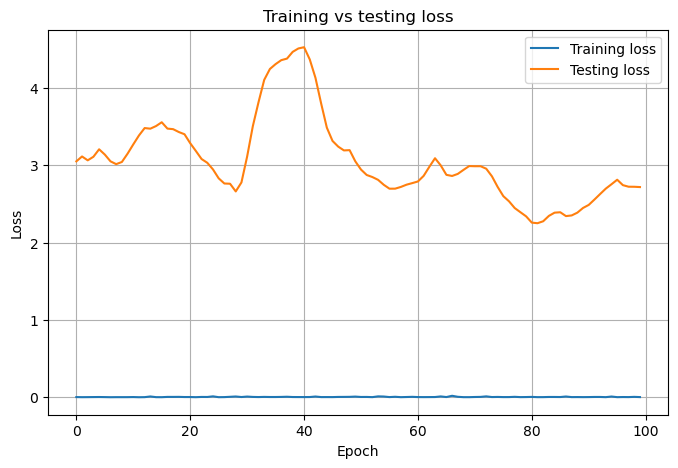

Train F1: 0.9968 
Test F1: 0.6903
Epoch [10/100], Train Loss: 0.0066, Test Loss: 3.0321
Epoch [20/100], Train Loss: 0.0052, Test Loss: 2.9128
Epoch [30/100], Train Loss: 0.0051, Test Loss: 3.0862
Epoch [40/100], Train Loss: 0.0035, Test Loss: 3.0448
Epoch [50/100], Train Loss: 0.0044, Test Loss: 3.1616
Epoch [60/100], Train Loss: 0.0019, Test Loss: 3.0536
Epoch [70/100], Train Loss: 0.0013, Test Loss: 2.9294
Epoch [80/100], Train Loss: 0.0017, Test Loss: 2.6510
Epoch [90/100], Train Loss: 0.0032, Test Loss: 2.9525
Epoch [100/100], Train Loss: 0.0052, Test Loss: 2.6988


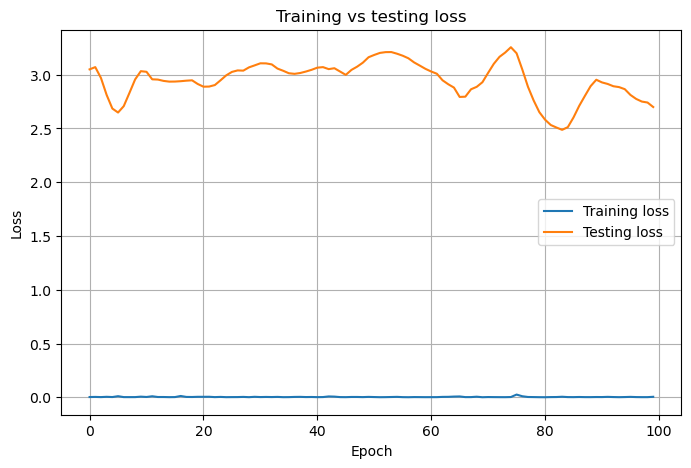

Train F1: 0.9981 
Test F1: 0.6731
Epoch [10/100], Train Loss: 0.0028, Test Loss: 2.6223
Epoch [20/100], Train Loss: 0.0024, Test Loss: 2.7644
Epoch [30/100], Train Loss: 0.0027, Test Loss: 2.8868
Epoch [40/100], Train Loss: 0.0020, Test Loss: 2.9253
Epoch [50/100], Train Loss: 0.0022, Test Loss: 2.9238
Epoch [60/100], Train Loss: 0.0018, Test Loss: 2.9902
Epoch [70/100], Train Loss: 0.0018, Test Loss: 3.0648
Epoch [80/100], Train Loss: 0.0029, Test Loss: 3.0515
Epoch [90/100], Train Loss: 0.0019, Test Loss: 3.0237
Epoch [100/100], Train Loss: 0.0018, Test Loss: 2.8778


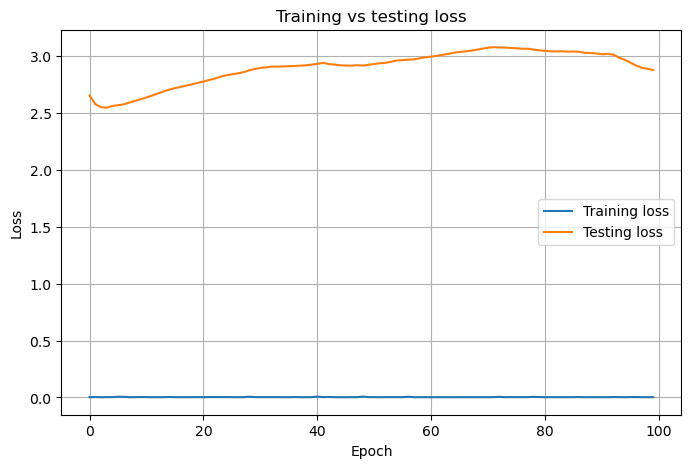

Train F1: 0.9987 
Test F1: 0.7303
ur done queen


In [65]:
learning_rates = [0.0005, 0.001, 0.002, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.09]
length = len(learning_rates)
best_params = {"train f1:": 0, "test f1": 0, "learning rate": 0}
for i in range(length):
    lr_ = random.choice(learning_rates)
    learning_rates.remove(lr_)
    optimizer = torch.optim.Adam(model_3.parameters(), lr = lr_)
    run_and_plot(model_3, optimizer, criterion, num_epochs = 100)
    train_f1, test_f1 = get_f1(model_3)
    if test_f1 > best_params["test f1"]:
        best_params["test f1"] = test_f1
        best_params["train_f1"] = train_f1
        best_params["learning rate"] = lr_

print("ur done queen")

In [70]:
print("Best parameters:")
print(f'\tTrain F1: {best_params["train_f1"]: .4f} \n\tTest F1: {best_params["test f1"]: .4f} \n\tLearning rate: {best_params["learning rate"]}')

Best parameters:
	Train F1:  0.9987 
	Test F1:  0.7303 
	Learning rate: 0.0025


The best parameter is 0.0025 and the train F1 is very high so theres no bias problem, we keep this.

The model is overfitting tho so we have to apply regularization techniques, dropout is already implemented so: L1/L2 regularization, early stopping, batch normalization, data augmentation.

#### Regularization techniques 